In [1]:
from opcua import Client, ua
import logging
from MyPlots.InteractivePlots import simplePlot
import numpy as np
import pickle
from plotly.offline import init_notebook_mode, iplot
import time
init_notebook_mode(connected=True)


In [2]:
# Import Orange3 Model
with open("../WineTestMLP.pkcls", 'rb') as f:
    model = pickle.load(f)

# get skl model
sklModel = model.skl_model
sklModel

MLPRegressorWCallback(alpha=0.05, hidden_layer_sizes=(100, 50, 20, 50, 100),
                      max_iter=5000, random_state=1)

In [3]:
# configure client
logging.basicConfig(level=logging.WARN)

client = Client(url='opc.tcp://localhost:4840/')
client.set_user("mag")
client.set_password("MAR")
client.set_security_string("Basic256Sha256,SignAndEncrypt,cert.der,key.pem")
client.application_uri = "urn:WineTestComm:client"

In [4]:
# common server browsing functions   
def find_PrgNode(Node, prgName="PLC_PRG"):
    children = Node.get_children()
    
    # BFS Search
    for child in children:
        if child.get_display_name().Text == prgName:
            return child
        
    # nothing found -> look at each child
    for child in children:
        search_result = find_PrgNode(child, prgName)
        if search_result is not None:
            return search_result
        
    return None

def get_DeviceSetNode(client):
    # get starting node
    objects = client.get_objects_node()
    
    for node in objects.get_children():
        if node.get_display_name().Text == "DeviceSet":
            return node
    
    print("ERROR: DeviseSet Node not found")
    
def get_MLPnode(prgNode):  
    for child in prgNode.get_children():
        if child.get_display_name().Text == "WT_MLP":
            return child
        
def get_MLPinputs(MLPnode):
    inputs = 11*[None]
    
    for child in MLPnode.get_children():
        name = child.get_display_name().Text
        if "in" in name:
            inputs[int(name.split("_")[1]) - 1] = child

    return inputs    

def get_MLPoutput(MLPnode):
    for child in MLPnode.get_children():
        name = child.get_display_name().Text
        if "out" in name:
            return child
        

In [5]:
# test function for MLP
def testMLP(inNodes, outNode, o3Model, sklModel, nTestCases=100):
    # MLP data was normalised to [0, 1] range
    test_input = np.random.random((nTestCases, 11))
    # get MLP data (compare orange3 and sklearn -> should be identical)
    o3Pred = o3Model.predict(test_input)
    sklPred = sklModel.predict(test_input)
    
    PLC_Pred = list(map(lambda input_: call_PLC_MLP(input_, inNodes, outNode), test_input))
    
    return simplePlot(x=[np.arange(nTestCases)], y=[o3Pred, sklPred, PLC_Pred],
                      names=['orange3', 'sklearn', 'PLC'],
                      xlabel='Test case', ylabel='MLP prediction',
                      LineTypes=['solid', 'dash', 'solid'],
                      mode=['lines', 'lines', 'markers']
                      )

def call_PLC_MLP(inputs, inNodes, outNode):
    for idx in range(11):
        inNodes[idx].set_value(inputs[idx], ua.VariantType.Float)
        
    # wait for calculation
    time.sleep(0.05)
    
    return outNode.get_value()
    

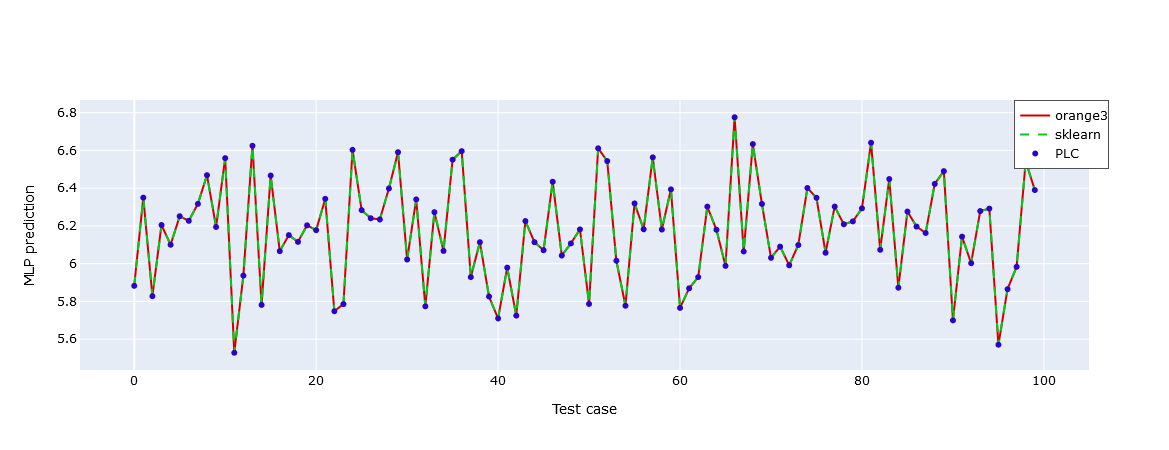

In [6]:
# start communication
if __name__ == "__main__":
    try:
        client.connect()
        objects = client.get_objects_node()
        # work in DeviceSet Branch, since it has less side nodes
        devSetNode = get_DeviceSetNode(client)
        prgNode = find_PrgNode(devSetNode)
        MLPnode = prgNode.get_children()[0]
        # relevant MLP nodes
        inNodes = get_MLPinputs(MLPnode)
        outNode = get_MLPoutput(MLPnode)
        # run test
        graph = testMLP(inNodes, outNode, model, sklModel)
        iplot(graph)
            
    finally:
        client.disconnect()